In [1]:
import torch
import torch.nn as nn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [3]:
from dataset import Dataset, Sample
import utils

In [4]:
ds = Dataset.Load("../gds/training") # Load the dataset

In [5]:
class PreprocessedSample(object):
    def __init__(self, sample: Sample, n=64):
        trajectory = utils.resample(sample.trajectory, n)
        trajectory = utils.scale_to_unit_square(trajectory)
        vecs = utils.vectorize(trajectory)

        self.trajectory = trajectory
        self.vecs = vecs
        self.gname = sample.gname

In [6]:
# Resample, scale, translate and convert to floats
preprocessed_samples = []
for i, s in enumerate(ds.samples):
    ps = PreprocessedSample(s, 100)
    if i % 1000 == 0 and i > 0:
        print(f"processed {i} samples")
    preprocessed_samples.append(ps)

processed 1000 samples
processed 2000 samples
processed 3000 samples
processed 4000 samples


In [7]:
preprocessed_x = np.array([p.trajectory.flatten() for p in preprocessed_samples])
preprocessed_x = preprocessed_x.astype(np.float32)
print(preprocessed_x.shape)

(4800, 200)


In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [9]:
# Encode labels
preprocessed_y = [p.gname for p in preprocessed_samples]
preprocessed_y = np.array(preprocessed_y).reshape(-1, 1)
oh = OneHotEncoder()
oh.fit(preprocessed_y)
preprocessed_y = oh.transform(preprocessed_y).toarray()
preprocessed_y = preprocessed_y.astype(np.float32)
print(preprocessed_y.shape)

(4800, 16)


In [10]:
# Split the data into training and testing and save locally for quick loads in the future
X_train, X_test, y_train, y_test = train_test_split(preprocessed_x, preprocessed_y, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=preprocessed_y)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

In [11]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([3840, 200])
torch.Size([960, 200])
torch.Size([3840, 16])
torch.Size([960, 16])


## Define our LSTM Network

In [12]:
from torch.utils.data import Dataset

class TimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.len

dataset = TimeSeries(X_train, y_train)

# data loader
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

C:\Users\musta\AppData\Local\Temp/ipykernel_15544/3251835444.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
C:\Users\musta\AppData\Local\Temp/ipykernel_15544/3251835444.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [13]:
class LSTMNetwork(nn.Module):
    def __init__(self, num_features, num_classes):
        super(LSTMNetwork, self).__init__()
        self.num_features = num_features
        self.num_classes = num_classes

        # Encoder
        self.lstm1 = nn.LSTM(num_features, 128, 1, batch_first=True)
        self.lstm2 = nn.LSTM(num_features, 128, 1, batch_first=True)
        # self.lstm2 = nn.LSTM(input_size=8, hidden_size=5, num_layers=1, batch_first=True)

        # Classifier
        # self.classifier = nn.Sequential()
        self.classifier = nn.Linear(128, 16)

    def forward(self, x):
        output, _status = self.lstm1(x)
        output = output[:, -1, :]
        
        output, _status = self.lstm2(x)
        output = output[:, -1, :]
        
        output = self.classifier(torch.relu(output))
        # output = self.classifier(output)
        return output


In [14]:
model = LSTMNetwork(num_features=200, num_classes=16)

In [15]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 400

In [16]:

import time
time_start = time.perf_counter()

train_loss, test_loss = {}, {}
train_accuracy, test_accuracy = {}, {}

for e in range(epochs):

    # Train
    
    model.train()
    if e < int(epochs * .8):
        for j, (batch, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(batch.view(-1, 1, 200)).reshape(-1, 16)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
    else:
        optimizer.zero_grad()
        outputs = model(X_train.view(-1, 1, 200)).reshape(-1, 16)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    # Evaluate
    with torch.no_grad():

        # performance on testing samples
        outputs = model(X_test.view(-1, 1, 200)).reshape(-1, 16)
        loss = criterion(outputs, y_test)

        test_loss[e] = loss.item()
        test_accuracy[e] = outputs.argmax(dim=1).eq(
            y_test.argmax(dim=1)).sum().item() / y_test.shape[0]

        # performance on training samples
        outputs = model(X_train.view(-1, 1, 200)).reshape(-1, 16)
        loss = criterion(outputs, y_train)

        train_loss[e] = loss.item()
        train_accuracy[e] = outputs.argmax(dim=1).eq(
            y_train.argmax(dim=1)).sum().item() / y_train.shape[0]

    if e % 50 == 0:
        print(
            f"Epoch [{e}/{epochs}], Loss: {float(loss.item()):1.6f}")


Epoch [0/400], Loss: 0.052741
Epoch [50/400], Loss: 0.002865
Epoch [100/400], Loss: 0.001708
Epoch [150/400], Loss: 0.001203
Epoch [200/400], Loss: 0.000928
Epoch [250/400], Loss: 0.000749
Epoch [300/400], Loss: 0.000623
Epoch [350/400], Loss: 0.000568


In [17]:
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [18]:
def plot_all_losses(train_l=None, test_l=None, train_ac=None, test_ac=None, title=None):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), dpi=100)
    
    if title:
        fig.suptitle(title)
    if train_l:
        axes[0][0].plot(train_l)
        axes[0][0].set_title("Training Loss")
    if test_l:
        axes[0][1].plot(test_l)
        axes[0][1].set_title("Test Loss")
    if train_ac:
        axes[1][0].plot(train_ac)
        axes[1][0].set_title("Training Accuracy")
    if test_ac:
        axes[1][1].plot(test_ac)
        axes[1][1].set_title("Test Accuracy")

    plt.tight_layout()


Training data accuracy 0.9987
Testing data accuracy 0.9938


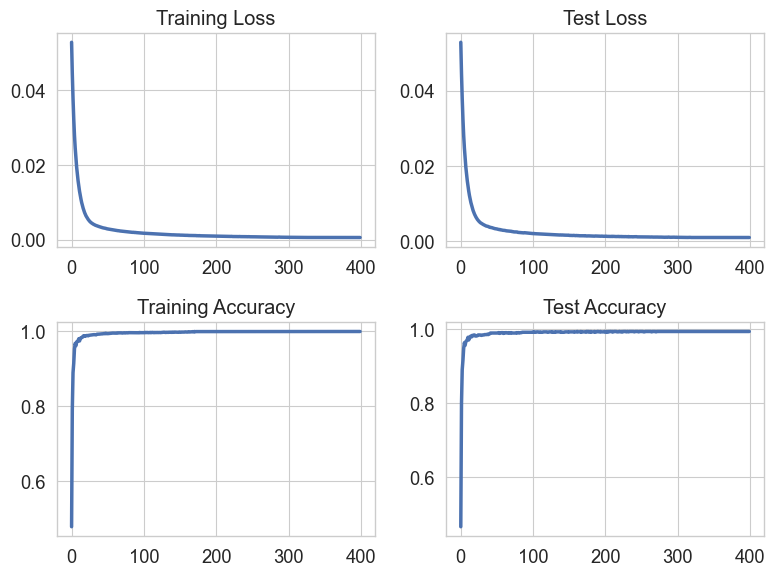

In [19]:
# Final performance metrics and plots
train_pred = model(X_train.view(-1, 1, 200)).reshape(-1, 16)
correct_count = train_pred.argmax(dim=1).eq(y_train.argmax(dim=1)).sum().item()
print(f"Training data accuracy {float(correct_count / y_train.shape[0]):1.4}")

test_pred = model(X_test.view(-1, 1, 200)).reshape(-1, 16)
correct_count = test_pred.argmax(dim=1).eq(y_test.argmax(dim=1)).sum().item()
print(f"Testing data accuracy {float(correct_count / y_test.shape[0]):1.4}")


train_losses = list(train_loss.values())
train_accuracies = list(train_accuracy.values())
test_losses = list(test_loss.values())
test_accuracies = list(test_accuracy.values())

plot_all_losses(train_losses, test_losses, train_accuracies, test_accuracies)#, "Losses and Accuracy")